## Imports
Importing all required modules

In [1]:
from random import randint, shuffle, random # random integers and random shuffling of a list
from itertools import permutations # iterate over all possible permutations of a list
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt, log, factorial  # square root, logarithm, and n!
from time import perf_counter # for measuring time. NB. 'perf_counter' is better/more accurate than 'time'
import networkx as nx # to draw sample graphs
import pandas as pd # to show the adjacency matrix in a nice format
import matplotlib.pyplot as plt # to plot graphs of time and quality vs n
import seaborn as sns # nice statistical plots -- see e.g. https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
import numpy as np
sns.set_style("white")

## Defining a Graph
Graph class for creating graphs to use with algorithms. All graphs are complete and weighted.

Supports 4 types of graphs:
- `asymmetric`: Directed graph with random weights
- `symmetric`: Undirected graph with random weights
- `easy`: All edges have the weight 2, except for a cycle which has edges with the weight 1
- `Euclidean`: Vertices placed on a 2D coordinate plane and the weight of the edges is the Euclidean distance between them

Examples:
- Creating a Euclidean graph with 10 vertices: `G = Graph(10, 'Euclidean')`
- Getting the number of vertices: `G.n`
- Getting the weight of the edge from $a$ to $b$: `G[a][b]`

In [2]:
class Graph:
    ''' Random graphs '''
    def __init__(self, n=0, type='asymmetric', MAX_WEIGHT=100, MAX_X=200, MAX_Y=200):
        self.n = n
        self.vertices = list(range(n)) # [0,1,...,n-1]
        self.type = type
        self.adj_matrix = [[oo for i in range(n)] for j in range(n)]
        # Generate a random adjacency matrix according to the required type
        if   type=='symmetric': self.__random_symmetric_graph(n,MAX_WEIGHT)
        elif type=='Euclidean': self.__random_euclidean_graph(n,MAX_X,MAX_Y)
        elif type=='easy':      self.__random_cycle_graph(n)
        else:                   self.__random_asymmetric_graph(n,MAX_WEIGHT) # assume 'asymmetric' otherwise
            
    def __getitem__(self, i):
        ''' Allow indexing to get the weights '''
        return self.adj_matrix[i]
                
    def __random_asymmetric_graph(self,n, MAX_WEIGHT):
        ''' Asymmetric adjacency matrix of size nxn '''
        for i in range(n):
            for j in range(n):
                if i==j: continue # no self-loops
                self.adj_matrix[i][j] = randint(1,MAX_WEIGHT)

    def __random_symmetric_graph(self,n,MAX_WEIGHT):
        ''' Symmetric adjacency matrix of size nxn '''
        for i in range(n):
            for j in range(i+1,n):
                w = randint(1,MAX_WEIGHT)
                self.adj_matrix[i][j] = w
                self.adj_matrix[j][i] = w

    def __random_cycle_graph(self,n):
        ''' Symmetric adjacency matrix of size nxn with one reandomly chosen cycle
        All the edge weights are 2 except for the cycle (weight=1) '''
        self.adj_matrix = [[2 for _ in range(n)] for _ in range(n)] # All weights=2
        # Select a random cycle which will have weight=1
        cycle = list(range(1,n)) # don't include 0 as we want to be at the start
        shuffle(cycle) # in-place random permutation
        cycle = [0]+cycle+[0] # cycle starting and ending at 0
        for a,b in zip(cycle, cycle[1:]): # set the cycle's weights to 1
            self.adj_matrix[a][b] = 1
            self.adj_matrix[b][a] = 1

    def __random_euclidean_graph(self,n,MAX_X,MAX_Y):
        ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
        # (1/2) Generate random (x,y) points
        points = set()
        while len(points)<n: # We may get duplicate (x,y) so we try until we get enough points
            x,y = randint(0,MAX_X), randint(0,MAX_Y)
            points.add((x,y))
        points = list(points) # Sets are not indexed, so convert into a list
        # (2/2) Now compute the adjacency matrix
        for i in range(n):
            p1 = points[i]
            for j in range(i+1,n):
                p2 = points[j]
                distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
                self.adj_matrix[i][j] = distance
                self.adj_matrix[j][i] = distance
        self.points=points

### Utility functions on the Graph

- **cost(Graph, cycle)**: Calculates the cost of a cycle in the graph (The first and last elements need to be the same in the cycle).
- **show(Graph)**: Displays the adjacency matrix of the graph.
- **draw(Graph, path?)**: Draws the graph. If a path is specified, only draws the edges in the path. The weight of the edges is not shown for graphs that have more than 15 vertices.

In [3]:
def cost(G, cycle):
    ''' Calculate the cost of the given cycle [0,...,0] in G '''
    return sum(G[a][b] for a,b in zip(cycle, cycle[1:]))

In [4]:
def show(G):
    ''' Show adjacency matrix. Useful for debugging.
    'type' is a string from: Euclidean, Cycle, ...
    The distances are round to 1 decimal point for clarity/simplicity
    '''
    print(f"{G.n}x{G.n} {G.type} graph:")
    if G.type=='Euclidean': print("Points:",G.points)
    r = pd.DataFrame({str(i): G[i] for i in range(G.n)})
    display(r)
    
def nx_graph(G, path=None):
    ''' Convert G into NetworkX format '''
    nxG = nx.Graph() if G.type!='asymmetric' else nx.DiGraph() # undirected/directed graph
    nxG.add_nodes_from(G.vertices) # Add the vertices
    # Now add the edges
    if path is None:
        # If no specific path is given - Add all edges
        for a in G.vertices:
            for b in G.vertices:
                if a==b: continue # no self-loops
                nxG.add_edge(a, b, weight=G[a][b])
    else:
        # If paht is given - Add only edges specified in path
        for i in range(len(path) - 1):
            a = path[i]
            b = path[i + 1]
            nxG.add_edge(a, b, weight=G[a][b])
        # Add last edge
        a = path[-1]
        b = path[0]
        nxG.add_edge(a, b, weight=G[a][b])
    if G.type=='Euclidean': # add (x,y) coordinates if available
        pos=dict(enumerate(G.points)) # vertex:(x,y) pairs
        nx.set_node_attributes(nxG, pos, 'coord')
    return nxG

def draw(G, path=None):
    ''' Draw the graph G using NetworkX '''
    nxG = nx_graph(G, path)
    weights_dictionary = nx.get_edge_attributes(nxG,'weight')
    edges,weights = zip(*weights_dictionary.items())
    pos = nx.circular_layout(nxG) if G.type!='Euclidean' else nx.get_node_attributes(nxG,'coord')
    nx.draw(nxG, pos, \
            with_labels=True, node_color='red', font_color='white', font_weight='bold', font_size=14,\
            edge_color=weights, width=1.5, connectionstyle="arc3,rad=0.1", edge_cmap=plt.cm.copper)
    # see https://matplotlib.org/stable/gallery/color/colormap_reference.html
    if G.n < 15:
        nx.draw_networkx_edge_labels(nxG, pos, edge_labels=weights_dictionary)

Example

10x10 easy graph:


,0,1,2,3,4,5,6,7,8,9
0,2,2,2,1,2,2,1,2,2,2
1,2,2,1,2,2,2,2,2,1,2
2,2,1,2,2,2,2,2,1,2,2
3,1,2,2,2,1,2,2,2,2,2
4,2,2,2,1,2,2,2,1,2,2
5,2,2,2,2,2,2,1,2,2,1
6,1,2,2,2,2,1,2,2,2,2
7,2,2,1,2,1,2,2,2,2,2
8,2,1,2,2,2,2,2,2,2,1
9,2,2,2,2,2,1,2,2,1,2


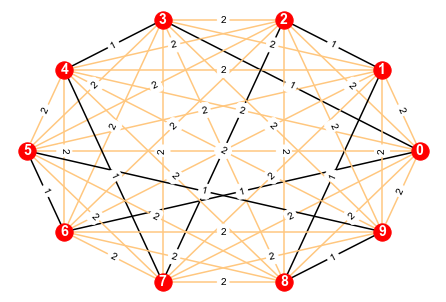

In [5]:
G = Graph(10, 'easy')
show(G)
draw(G)

## Metaheuristic algorithm 1: **Ant Colony Optimisation**

Ant Colony Optimisation algorithm is a biologically-inspired metaheuristic which searches solution space by emulating the way ant colonies search for food.

Ants are able to locate food and without any direct form of communication with the colony they can coordinate retrieving it. The communication between ants happens through the use of pheromone. Once food is found ants leave the pheromone on their path. As more pheromone builds up, more ants will follow the discovered path to the food.

The algorithm can be implemented in roughly the following steps:
1. Put ants on random cities.
1. For each ant, send the ant to all the other cities where they visit each city only once. The selection for which city to visit is initially random. After the first run, the next city selection becomes gradually more influenced by the amount of pheromone on a possible trail.
1. Once all ants have completed a tour of all cities, deposit pheromone on all paths. The amount of pheromone deposited by each ant is proportional to the length of the path traveled by the given ant.
1. Repeat the previous steps for multiple generations of ants.

At each city, a probability distribution for next city selection from a list of possibilities is generated according to the following:

$\Large p_{ij} = \frac{(\tau_{ij}^{\alpha}) (\eta_{ij}^{\beta})}{\sum_{h \in E} (\tau_{ih}^{\alpha}) (\eta_{ih}^{\beta})}$

Where:
- **$i$** is the current city
- **$j$** is an unvisited city
- **$\tau$** is the amount of pheromone on the trail between city i and city j
- **$\eta$** is the desirability of city i relative to city j (formulated as the inverse of the distance between i and j)
- **$\alpha$** is the weighting factor for the pheromone
- **$\beta$** is the weighting factor for the desirability
- **$h$** is a city from the list of available (unvisited) cities
- **$E$** is a list of available (unvisited) cities

Originally introduced in paper:
[Ant system: optimization by a colony of cooperating agents](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=484436)


Implementation from paper:
[Travel Time Optimization Problem via Ant Colony and Genetic Evolution](https://static1.squarespace.com/static/59d9b2749f8dce3ebe4e676d/t/5dfaa5e3f9cc2c0a44498c7a/1576707559712/Final-Report.pdf)

Source code based on:
https://github.com/khanhnamle1994/trip-optimizer/blob/master/Bio-Inspired-Algorithms/aco.py

Related sources:
- [Paper: A Comparative Study of Three Metaheuristics Applied to the Traveling Salesman Problem](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4659314)
- [Blog: Python Ant Colony Optimisation Implementation](https://www.aransena.com/blog/2015/12/22/python-ant-colony-optimization)

Complexity: $O(NC \times n^{2} \times m)$

### Implementation

In [6]:
class AntColonyOptimisation:
    def __init__(self, ant_count=10, generations=100, alpha=1.0, beta=10.0, \
                 residual_coefficient=0.5, pheromone_intensity=10.0, verbose=False):
        self.ant_count = ant_count  # Ants per generation
        self.generations = generations  # Total ant generations
        self.alpha = alpha  # Relative importance of pheromone
        self.beta = beta  # Relative importance of desirability
        self.residual_coefficient = residual_coefficient  # Pheromone residual coefficient
        self.pheromone_intensity = pheromone_intensity  # Pheromone intensity
        self.verbose = verbose  # Whether should print intermediate decisions
    
    def solve(self, graph):
        best_cost = float('inf')
        best_solution = []
        avg_costs = []
        best_costs = []
        
        # Pheromones is a N by N matrix with each initial pheromone set as 1 / (N**2),
        # where N is the number of cities in the graph
        pheromones = [[1 / (graph.n ** 2) for j in range(graph.n)] for i in range(graph.n)]
        
        for generation in range(self.generations):
            ants = [Ant(self, graph, pheromones) for i in range(self.ant_count)]
            for ant in ants:
                curr_cost = []
                for i in range(graph.n - 1):
                    # Move the ant between all cities
                    ant.select_next_city()
                # Update ant total cost to include the distance from the last city to the first city
                ant.total_cost += ant.get_distance(ant.start)
                # Update costs
                curr_cost.append(ant.total_cost)
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = ant.path.copy()
                # Update ant pheromone delta
                ant.update_pheromone_delta()
            # Update pheromones
            self.update_pheromones(pheromones, ants)
            # Update costs
            best_costs.append(best_cost)
            avg_costs.append(np.mean(curr_cost))
            # Debugging
            if self.verbose:
                print('Generation #{} best cost: {}, av cost: {}, path: {}'.format(
                    generation + 1, best_cost, avg_costs[-1], best_solution))
        return best_solution, best_cost
            
    
    def update_pheromones(self, pheromones, ants):
        for i, row in enumerate(pheromones):
            for j, col in enumerate(row):
                pheromones[i][j] *= self.residual_coefficient
                for ant in ants:
                    pheromones[i][j] += ant.pheromone_delta[i][j]

In [7]:
class Ant:
    def __init__(self, ant_colony, graph, pheromones):
        self.ant_colony = ant_colony
        self.graph = graph
        self.pheromones = pheromones
        self.total_cost = 0.0
        self.path = []  # List of the path taken by the ant
        self.pheromone_delta = []  # The local increase of pheromone
        # Cities which are available for next selection
        self.allowed_cities = graph.vertices.copy()
        # Create an N by N matrix with the desirability of each city
        # formulated as the inverse of the distance between cities
        self.desirability = [[0 if i == j else (1 / graph[i][j]) for j in graph.vertices] for i in graph.vertices]
        
        self.start = randint(0, graph.n - 1)  # Start from any node
        self._move_to_city(self.start)
    
    def select_next_city(self):
        """Select the next city to move to influenced by the pheromone and move the ant to that city"""
        denominator = 0
        for i in self.allowed_cities:
            denominator += self._get_pheromone(i)  * self._get_desirability(i)
        
        # Probability for moving to a city in the next step
        probabilities = [0 for i in self.graph.vertices]
        for i in self.graph.vertices:
            if denominator == 0 or i not in self.allowed_cities:
                continue
            probabilities[i] = self._get_pheromone(i)  * self._get_desirability(i) / denominator
        
        # Select next city randomly based on the probabilities
        # Visited cities have a probability of 0, so they won't be chosen
        next_city = np.random.choice(self.graph.vertices, p=probabilities)
        
        self.total_cost += self.get_distance(next_city)
        self._move_to_city(next_city)
    
    def update_pheromone_delta(self):
        """Place pheromone on the path proportional to the total cost of the path"""
        self.pheromone_delta = [[0 for j in self.graph.vertices] for i in self.graph.vertices]
        for _ in range(1, len(self.path)):
            i = self.path[_ - 1]
            j = self.path[_]
            self.pheromone_delta[i][j] = self.ant_colony.pheromone_intensity / self.total_cost
        
    def get_distance(self, city):
        """Get the distance of moving to the next city"""
        return self.graph[self.current][city]
    
    def _get_pheromone(self, city):
        """Get the pheromone to the city from the current location with the relative imporance"""
        return self.pheromones[self.current][city] ** self.ant_colony.alpha
    
    def _get_desirability(self, city):
        """Get the desirability to the city from the current location with the relative importance"""
        return self.desirability[self.current][city] ** self.ant_colony.beta
    
    def _move_to_city(self, city):
        """Move from the current city to the new city and update lists"""
        self.current = city
        self.path.append(city)
        self.allowed_cities.remove(city)

### Example

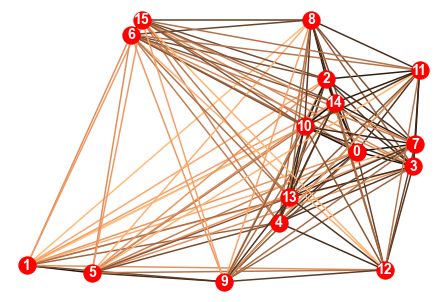

In [8]:
G = Graph(16, 'Euclidean')
# show(G)
draw(G)

Generation #1 best cost: 834.1916967871957, av cost: 932.43138507734, path: [5, 1, 9, 4, 13, 0, 10, 14, 2, 8, 15, 6, 11, 7, 3, 12]
Generation #2 best cost: 827.2058395011939, av cost: 909.776431072709, path: [2, 14, 10, 0, 3, 7, 11, 8, 15, 6, 1, 5, 9, 4, 13, 12]
Generation #3 best cost: 799.3282771364399, av cost: 934.0968637665678, path: [11, 14, 2, 10, 0, 7, 3, 13, 4, 12, 9, 5, 1, 15, 6, 8]
Generation #4 best cost: 779.5723257702653, av cost: 1005.1219715735192, path: [4, 13, 0, 7, 3, 10, 14, 2, 11, 8, 15, 6, 1, 5, 9, 12]
Generation #5 best cost: 769.4967625380516, av cost: 860.355777882608, path: [0, 7, 3, 12, 4, 13, 9, 5, 1, 6, 15, 8, 11, 2, 14, 10]
Generation #6 best cost: 769.4967625380516, av cost: 926.3256553425432, path: [0, 7, 3, 12, 4, 13, 9, 5, 1, 6, 15, 8, 11, 2, 14, 10]
Generation #7 best cost: 769.4967625380516, av cost: 979.6170396201103, path: [0, 7, 3, 12, 4, 13, 9, 5, 1, 6, 15, 8, 11, 2, 14, 10]
Generation #8 best cost: 769.4967625380516, av cost: 939.0616059883146, 

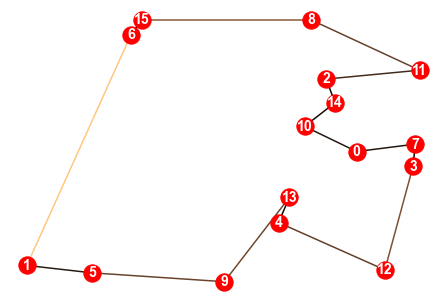

In [9]:
aco = AntColonyOptimisation(generations=10, ant_count=10, alpha=0.5, verbose=True)

path, cost = aco.solve(G)

print("Final cost", cost)
print("Final path", path)
draw(G, path)